YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Iteration 1/50
Final portfolio value: $167245522765571.75
Total return: 1672455227555.72%
Max drawdown: -22.32%
Win rate: 42.00%
Annualized Sharpe ratio: 1.60
Iteration 2/50
Final portfolio value: $384388305227271360.00
Total return: 3843883052272613.50%
Max drawdown: -21.27%
Win rate: 27.27%
Annualized Sharpe ratio: 1.46
Iteration 3/50
Final portfolio value: $4811518476458924.00
Total return: 48115184764489.24%
Max drawdown: -21.28%
Win rate: 34.09%
Annualized Sharpe ratio: 1.47
Iteration 4/50
Final portfolio value: $383225412872039808.00
Total return: 3832254128720298.50%
Max drawdown: -21.28%
Win rate: 34.09%
Annualized Sharpe ratio: 1.46
Iteration 5/50
Final portfolio value: $206267625669983.62
Total return: 2062676256599.84%
Max drawdown: -26.77%
Win rate: 43.59%
Annualized Sharpe ratio: 1.36
Iteration 6/50
Final portfolio value: $235642272224270.34
Total return: 2356422722142.70%
Max drawdown: -26.51%
Win rate: 23.53%
Annualized Sharpe ratio: 1.37
Iteration 7/50
Final portfolio v

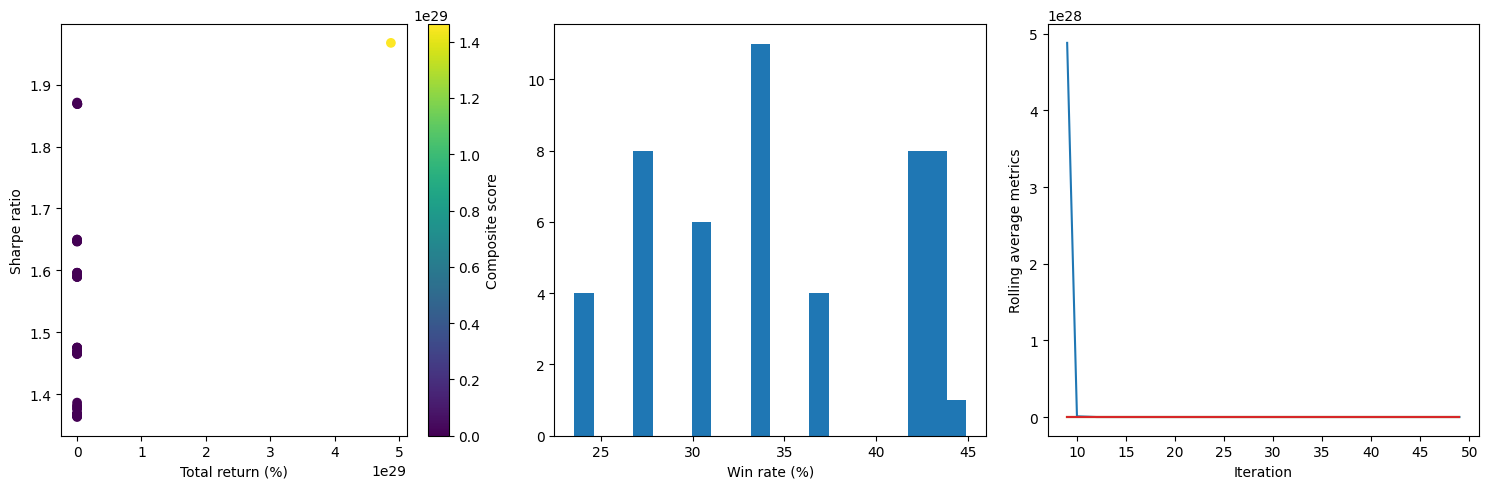

Final portfolio value: $48733835614941718165438683152384.00
Total return: 487338356149417142247890092032.00%
Max drawdown: -11.88%
Win rate: 44.93%
Annualized Sharpe ratio: 1.97


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from scipy import stats
from scipy.stats import jarque_bera, ttest_ind, wilcoxon

# ------------------------------
# 1. Download AAPL stock data from Yahoo Finance
# ------------------------------
tickers = ['AAPL']
data = yf.download(tickers, start='2020-01-01', end='2025-01-01')

# Flatten the MultiIndex columns by dropping the second level
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)

# Calculate candle components
data['Body'] = abs(data['Close'] - data['Open'])
data['Upper_Wick'] = data['High'] - data[['Open', 'Close']].max(axis=1)
data['Lower_Wick'] = data[['Open', 'Close']].min(axis=1) - data['Low']

# ------------------------------
# 2. Compute additional technical indicators
# ------------------------------
# 50-day moving average
data['MA50'] = data['Close'].rolling(window=50).mean()

# True range and ATR (using a 14-day window)
data['Prev_Close'] = data['Close'].shift(1)
data['True_Range'] = data[['High']].max(axis=1) - data[['Low']].min(axis=1)
# A more complete true range can use: max(High - Low, abs(High - Prev_Close), abs(Low - Prev_Close))
data['True_Range'] = np.maximum(data['High'] - data['Low'],
                                np.maximum(abs(data['High'] - data['Prev_Close']),
                                           abs(data['Low'] - data['Prev_Close'])))
data['ATR'] = data['True_Range'].rolling(window=14).mean()

# RSI function
def compute_RSI(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = compute_RSI(data['Close'])

# Drop rows with NaN values resulting from indicator calculations
data.dropna(inplace=True)

# ------------------------------
# 3. Candlestick pattern detection
# ------------------------------
def is_doji(row, threshold=0.1):
    return abs(row['Close'] - row['Open']) <= threshold * (row['High'] - row['Low'])

def is_spinning_top(row, threshold=0.5):
    return row['Body'] < threshold * (row['High'] - row['Low'])

def is_hammer(row):
    return (row['Lower_Wick'] >= 2 * row['Body']) and (row['Upper_Wick'] <= 0.25 * row['Body'])

def is_inverted_hammer(row):
    return (row['Upper_Wick'] >= 2 * row['Body']) and (row['Lower_Wick'] <= 0.25 * row['Body'])

def is_bullish_engulfing(prev, curr):
    return (prev['Close'] < prev['Open'] and
            curr['Close'] > curr['Open'] and
            curr['Open'] < prev['Close'] and
            curr['Close'] > prev['Open'])

def is_bearish_engulfing(prev, curr):
    return (prev['Close'] > prev['Open'] and
            curr['Close'] < curr['Open'] and
            curr['Open'] > prev['Close'] and
            curr['Close'] < prev['Open'])

def is_piercing_line(prev, curr):
    midpoint = (prev['Open'] + prev['Close']) / 2
    return (prev['Close'] < prev['Open'] and
            curr['Close'] > curr['Open'] and
            curr['Open'] < prev['Low'] and
            curr['Close'] > midpoint)

def is_dark_cloud_cover(prev, curr):
    midpoint = (prev['Open'] + prev['Close']) / 2
    return (prev['Close'] > prev['Open'] and
            curr['Close'] < curr['Open'] and
            curr['Open'] > prev['High'] and
            curr['Close'] < midpoint)

def is_morning_star(df, i):
    first = df.iloc[i - 2]
    second = df.iloc[i - 1]
    third = df.iloc[i]
    midpoint = (first['Open'] + first['Close']) / 2
    return (first['Close'] < first['Open'] and
            abs(second['Body']) < 0.5 * first['Body'] and
            third['Close'] > third['Open'] and
            third['Close'] > midpoint)

def is_evening_star(df, i):
    first = df.iloc[i - 2]
    second = df.iloc[i - 1]
    third = df.iloc[i]
    midpoint = (first['Open'] + first['Close']) / 2
    return (first['Close'] > first['Open'] and
            abs(second['Body']) < 0.5 * first['Body'] and
            third['Close'] < third['Open'] and
            third['Close'] < midpoint)

def is_three_white_soldiers(df, i):
    first = df.iloc[i - 2]
    second = df.iloc[i - 1]
    third = df.iloc[i]
    return (first['Close'] > first['Open'] and
            second['Close'] > second['Open'] and
            third['Close'] > third['Open'] and
            second['Open'] > first['Open'] and second['Close'] > first['Close'] and
            third['Open'] > second['Open'] and third['Close'] > second['Close'])

def is_three_black_crows(df, i):
    first = df.iloc[i - 2]
    second = df.iloc[i - 1]
    third = df.iloc[i]
    return (first['Close'] < first['Open'] and
            second['Close'] < second['Open'] and
            third['Close'] < third['Open'] and
            second['Open'] < first['Close'] and second['Close'] < first['Close'] and
            third['Open'] < second['Close'] and third['Close'] < second['Close'])

def is_falling_three_methods(df, i):
    first = df.iloc[i - 4]
    second = df.iloc[i - 3]
    third = df.iloc[i - 2]
    fourth = df.iloc[i - 1]
    fifth = df.iloc[i]
    return (first['Close'] < first['Open'] and
            second['Close'] > second['Open'] and abs(second['Body']) < 0.5 * first['Body'] and
            third['Close'] > third['Open'] and abs(third['Body']) < 0.5 * first['Body'] and
            fourth['Close'] > fourth['Open'] and abs(fourth['Body']) < 0.5 * first['Body'] and
            fifth['Close'] < fifth['Open'])

def is_rising_three_methods(df, i):
    first = df.iloc[i - 4]
    second = df.iloc[i - 3]
    third = df.iloc[i - 2]
    fourth = df.iloc[i - 1]
    fifth = df.iloc[i]
    return (first['Close'] > first['Open'] and
            second['Close'] < second['Open'] and abs(second['Body']) < 0.5 * first['Body'] and
            third['Close'] < third['Open'] and abs(third['Body']) < 0.5 * first['Body'] and
            fourth['Close'] < fourth['Open'] and abs(fourth['Body']) < 0.5 * first['Body'] and
            fifth['Close'] > fifth['Open'])

def is_hanging_man(row, body_position_threshold=0.1):
    # Ensure the candle is in an uptrend (price above MA50)
    if 'MA50' in row and row['Close'] < row['MA50']:
        return False

    # Check for a hammer shape: long lower wick and short upper wick
    if not ((row['Lower_Wick'] >= 2 * row['Body']) and (row['Upper_Wick'] <= 0.25 * row['Body'])):
        return False

    # For a hanging man, the candle's body should be near the top of its range.
    body_top = max(row['Open'], row['Close'])
    total_range = row['High'] - row['Low']
    if total_range == 0:
        return False
    # The distance from the body top to the high should be within a small fraction of the total range.
    return (row['High'] - body_top) <= (body_position_threshold * total_range)


def is_shooting_star(row, body_position_threshold=0.1):
    # Ensure the candle is in an uptrend (price above MA50)
    if 'MA50' in row and row['Close'] < row['MA50']:
        return False

    # Check for an inverted hammer shape: long upper wick and short lower wick
    if not ((row['Upper_Wick'] >= 2 * row['Body']) and (row['Lower_Wick'] <= 0.25 * row['Body'])):
        return False

    # For a shooting star, the candle's body should be near the bottom of its range.
    body_bottom = min(row['Open'], row['Close'])
    total_range = row['High'] - row['Low']
    if total_range == 0:
        return False
    # The distance from the body bottom to the low should be within a small fraction of the total range.
    return (body_bottom - row['Low']) <= (body_position_threshold * total_range)
    
# Single-day patterns
data['doji'] = data.apply(is_doji, axis=1)
data['spinning_top'] = data.apply(is_spinning_top, axis=1)
data['hammer'] = data.apply(is_hammer, axis=1)
data['inverted_hammer'] = data.apply(is_inverted_hammer, axis=1)
data['hanging_man'] = data.apply(is_hanging_man, axis=1)
data['shooting_star'] = data.apply(is_shooting_star, axis=1)

# Initialize multi-day patterns
multi_day_patterns = ['bullish_engulfing', 'bearish_engulfing', 'morning_star', 
                      'evening_star', 'three_white_soldiers', 'three_black_crows',
                      'rising_three_methods', 'falling_three_methods']
for pattern in multi_day_patterns:
    data[pattern] = False

# Populate multi-day patterns
for i in range(1, len(data)):
    prev = data.iloc[i-1]
    curr = data.iloc[i]
    data.at[curr.name, 'bullish_engulfing'] = is_bullish_engulfing(prev, curr)
    data.at[curr.name, 'bearish_engulfing'] = is_bearish_engulfing(prev, curr)

for i in range(2, len(data)):
    data.at[data.index[i], 'morning_star'] = is_morning_star(data, i)
    data.at[data.index[i], 'evening_star'] = is_evening_star(data, i)
    data.at[data.index[i], 'three_white_soldiers'] = is_three_white_soldiers(data, i)
    data.at[data.index[i], 'three_black_crows'] = is_three_black_crows(data, i)

for i in range(4, len(data)):
    data.at[data.index[i], 'falling_three_methods'] = is_falling_three_methods(data, i)
    data.at[data.index[i], 'rising_three_methods'] = is_rising_three_methods(data, i)

# ------------------------------
# 4. Trend and momentum filters
# ------------------------------
data['above_MA50'] = data['Close'] > data['MA50']
data['MA50_cross_above'] = (data['Close'] > data['MA50']) & (data['Close'].shift(1) <= data['MA50'].shift(1))
data['RSI_ok_long'] = data['RSI'] < 70
data['RSI_ok_short'] = data['RSI'] > 30

# ------------------------------
# 5. Signal generation logic
# ------------------------------
# Bullish pattern combinations
data['bullish_signal'] = (
    (data['hammer'].shift(1) & data['bullish_engulfing']) |
    (data['morning_star']) |
    (data['three_white_soldiers'])
)

# Bearish pattern combinations
data['bearish_signal'] = (
    (data['shooting_star'].shift(1) & data['bearish_engulfing']) |
    (data['evening_star']) |
    (data['three_black_crows'])
)

# Final entry signals with filters
data['long_entry'] = data['bullish_signal'] & (data['above_MA50'] | data['MA50_cross_above']) & data['RSI_ok_long']
data['short_entry'] = data['bearish_signal'] & (~data['above_MA50']) & data['RSI_ok_short']

# ------------------------------
# 6. Backtesting implementation
# ------------------------------
class Backtester:
    def __init__(self, data, params=None):
        self.data = data
        default_params = {
            'initial_capital': 10000,
            'risk_fraction': 0.2,       # risk 20% of cash per trade
            'atr_stop_mult': 1.5,       # stop loss = 1.5 * ATR
            'profit_multiplier': 2.0    # take profit = 2.0 * ATR
        }
        if params is None:
            params = default_params
        else:
            for key, value in default_params.items():
                params.setdefault(key, value)
        self.params = params
        self.initial_capital = self.params['initial_capital']
        self.position = None
        self.portfolio = {'cash': self.initial_capital, 'shares': 0}
        self.trade_log = []
        self.equity = []
    
    def run_backtest(self):
        for i, row in self.data.iterrows():
            self._update_equity(row)
            self._check_exits(row)
            self._check_entries(row)
        return self._generate_report()
    
    def _check_entries(self, row):
        if self.position is None:
            position_size = self.portfolio['cash'] * self.params['risk_fraction']
            risk_per_share = self.params['atr_stop_mult'] * row['ATR']
            
            if row['long_entry']:
                shares = position_size / (risk_per_share + 1e-6)
                entry_cost = shares * row['Close']
                if entry_cost > self.portfolio['cash']:
                    shares = self.portfolio['cash'] / row['Close']
                    entry_cost = shares * row['Close']
                self.portfolio['cash'] -= entry_cost
                self.portfolio['shares'] = shares
                self.position = {
                    'entry_price': row['Close'],
                    'stop_loss': row['Close'] - risk_per_share,
                    'take_profit': row['Close'] + self.params['profit_multiplier'] * risk_per_share,
                    'direction': 'long'
                }
                self.trade_log.append({'type': 'entry', 'date': row.name, 
                                         'price': row['Close'], 'direction': 'long'})
            
            elif row['short_entry']:
                shares = position_size / (risk_per_share + 1e-6)
                entry_credit = shares * row['Close']
                self.portfolio['cash'] += entry_credit
                self.portfolio['shares'] = -shares
                self.position = {
                    'entry_price': row['Close'],
                    'stop_loss': row['Close'] + risk_per_share,
                    'take_profit': row['Close'] - self.params['profit_multiplier'] * risk_per_share,
                    'direction': 'short'
                }
                self.trade_log.append({'type': 'entry', 'date': row.name, 
                                         'price': row['Close'], 'direction': 'short'})
    
    def _check_exits(self, row):
        if self.position:
            if self.position['direction'] == 'long':
                if row['Low'] <= self.position['stop_loss']:
                    self._close_position(row, 'stop_loss')
                elif row['High'] >= self.position['take_profit']:
                    self._close_position(row, 'take_profit')
            else:
                if row['High'] >= self.position['stop_loss']:
                    self._close_position(row, 'stop_loss')
                elif row['Low'] <= self.position['take_profit']:
                    self._close_position(row, 'take_profit')
    
    def _close_position(self, row, exit_type):
        close_price = self.position['stop_loss'] if exit_type == 'stop_loss' else self.position['take_profit']
        if self.position['direction'] == 'long':
            self.portfolio['cash'] += self.portfolio['shares'] * close_price
        else:
            self.portfolio['cash'] -= self.portfolio['shares'] * close_price
        self.trade_log.append({
            'type': 'exit',
            'date': row.name,
            'price': close_price,
            'direction': self.position['direction'],
            'reason': exit_type
        })
        self.portfolio['shares'] = 0
        self.position = None
    
    def _update_equity(self, row):
        equity = self.portfolio['cash']
        if self.position:
            if self.position['direction'] == 'long':
                equity += self.portfolio['shares'] * row['Close']
            else:
                equity -= self.portfolio['shares'] * row['Close']
        self.equity.append(equity)
    
    def _generate_report(self):
        returns = pd.Series(self.equity, index=self.data.index)
        returns_pct = returns.pct_change().fillna(0)
        total_return = (returns.iloc[-1] / self.initial_capital - 1) * 100
        max_dd = (returns / returns.cummax() - 1).min() * 100
        sharpe = returns_pct.mean() / (returns_pct.std() + 1e-6) * np.sqrt(252)
        trades = pd.DataFrame(self.trade_log)
        win_rate = None
        if not trades.empty:
            win_rate = (trades[trades['type'] == 'exit']['reason'] == 'take_profit').mean() * 100
        metrics = {
            'total_return': total_return,
            'max_drawdown': max_dd,
            'sharpe_ratio': sharpe,
            'win_rate': win_rate
        }
        print(f"Final portfolio value: ${returns.iloc[-1]:.2f}")
        print(f"Total return: {total_return:.2f}%")
        print(f"Max drawdown: {max_dd:.2f}%")
        print(f"Win rate: {win_rate:.2f}%" if win_rate is not None else "Win rate: N/A")
        print(f"Annualized Sharpe ratio: {sharpe:.2f}")
        return metrics, returns

# ------------------------------
# 7. Hyperparameter tuning implementation
# ------------------------------
def optimize_strategy(data, param_grid=None, n_iter=50):
    best_params = None
    best_score = -np.inf
    results = []
    
    default_grid = {
        'ma_window': [30, 50, 100],
        'rsi_long_thresh': [60, 65, 70],
        'rsi_short_thresh': [30, 35, 40],
        'atr_stop_mult': [1.0, 1.5, 2.0],
        'profit_multiplier': [1.5, 2.0, 3.0],
        'risk_fraction': [0.1, 0.2, 0.3],
        'initial_capital': [10000]
    } if param_grid is None else param_grid
    
    for it in range(n_iter):
        print(f"Iteration {it + 1}/{n_iter}")
        params = {k: np.random.choice(v) for k, v in default_grid.items()}
        try:
            bt = Backtester(data, params)
            metrics, _ = bt.run_backtest()
            
            # Use the metrics from the backtester
            total_return = metrics['total_return']
            sharpe = metrics['sharpe_ratio']
            max_dd = metrics['max_drawdown']
            win_rate = metrics['win_rate'] if metrics['win_rate'] is not None else 0
            
            score = (sharpe * 0.4 +
                     total_return * 0.3 +
                     (100 - abs(max_dd)) * 0.2 +
                     win_rate * 0.1)
            
            if score > best_score:
                best_score = score
                best_params = params
                
            results.append((params, metrics, score))
            
        except Exception as e:
            print(f"Skipping parameters {params} due to error: {str(e)}")
    
    results.sort(key=lambda x: x[2], reverse=True)
    return best_params, results

# Run optimization
best_params, optimization_results = optimize_strategy(data, n_iter=50)
print("Best parameters:", best_params)

# Visualize optimization results
def plot_optimization(results):
    scores = [r[2] for r in results]
    sharpe = [r[1]['sharpe_ratio'] for r in results]
    returns = [r[1]['total_return'] for r in results]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.scatter(returns, sharpe, c=scores, cmap='viridis')
    plt.colorbar(label='Composite score')
    plt.xlabel('Total return (%)')
    plt.ylabel('Sharpe ratio')
    
    plt.subplot(132)
    plt.hist([r[1]['win_rate'] for r in results if r[1]['win_rate'] is not None], bins=20)
    plt.xlabel('Win rate (%)')
    
    plt.subplot(133)
    plt.plot(pd.DataFrame([r[1] for r in results]).rolling(10).mean())
    plt.xlabel('Iteration')
    plt.ylabel('Rolling average metrics')
    
    plt.tight_layout()
    plt.show()

plot_optimization(optimization_results)

# Backtest with best parameters
if best_params is None:
    best_params = {'initial_capital': 10000, 'risk_fraction': 0.2, 'atr_stop_mult': 1.5, 'profit_multiplier': 2.0}

backtester = Backtester(data, best_params)
strategy_returns = backtester.run_backtest()[1]

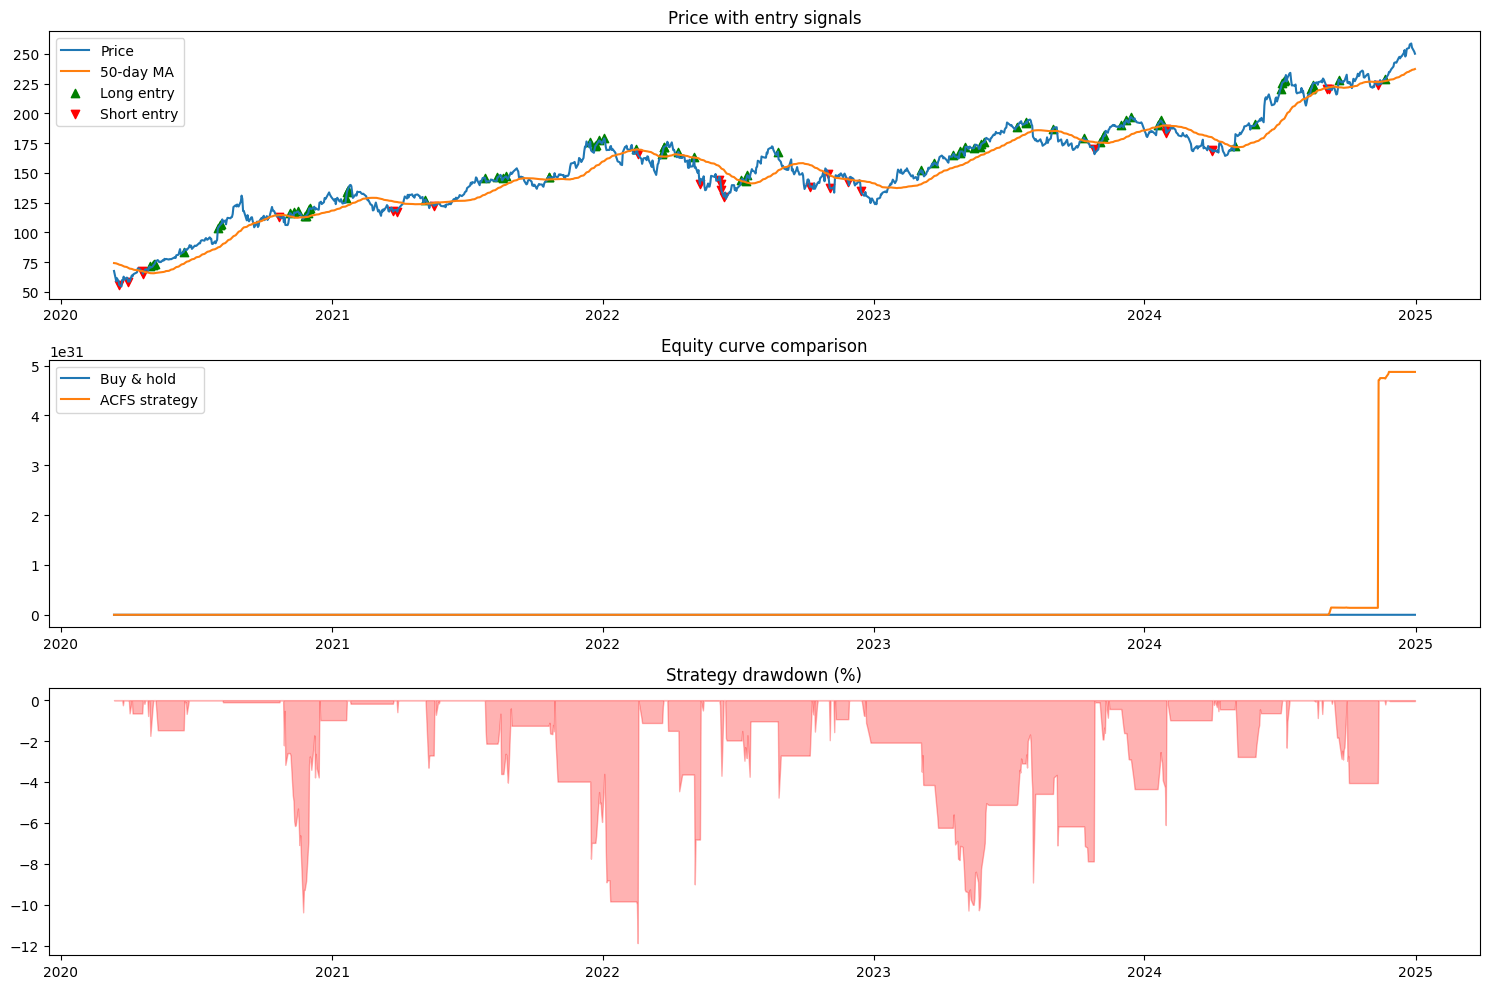

reason
stop_loss      38
take_profit    31
dtype: int64


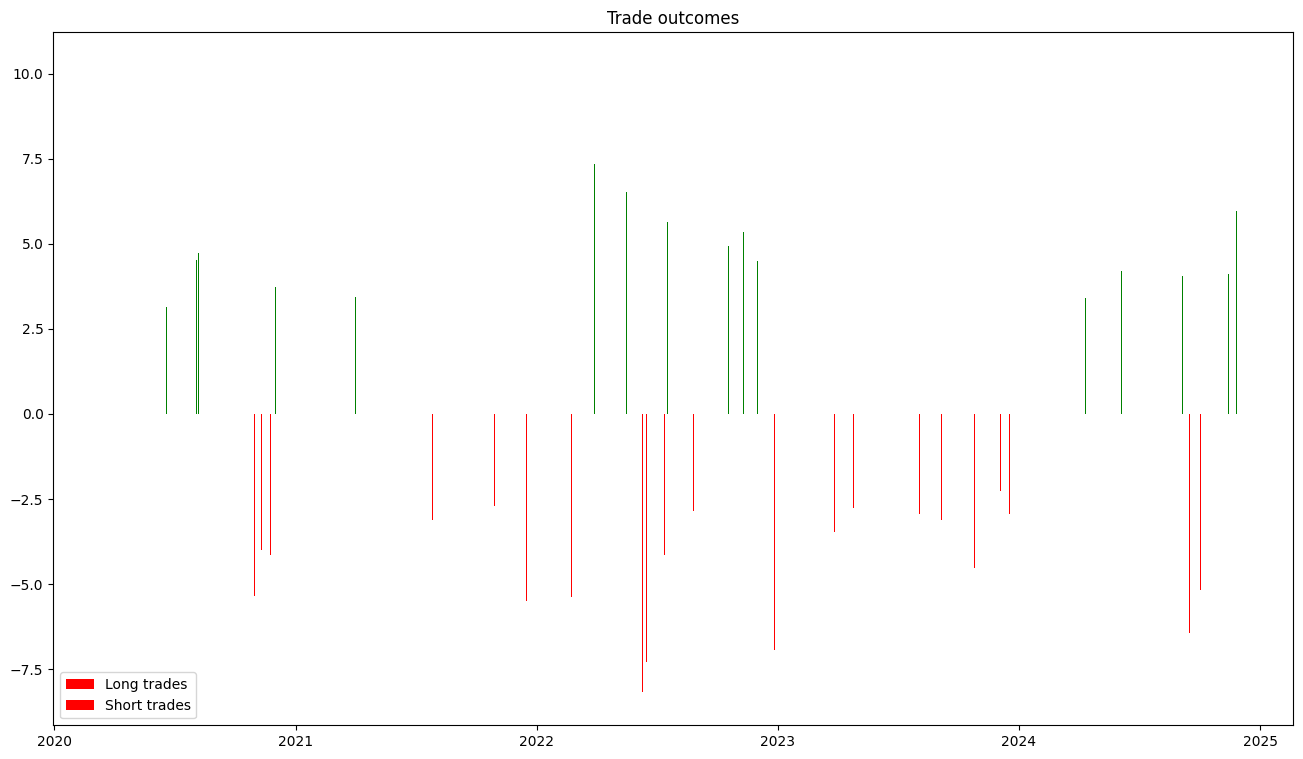

In [2]:
def plot_results(data, strategy_returns):
    plt.figure(figsize=(15, 10))
    
    # Price and MA50
    ax1 = plt.subplot(3, 1, 1)
    plt.plot(data['Close'], label='Price')
    plt.plot(data['MA50'], label='50-day MA')
    plt.scatter(data[data['long_entry']].index, 
                data[data['long_entry']]['Close'], 
                marker='^', color='g', label='Long entry')
    plt.scatter(data[data['short_entry']].index, 
                data[data['short_entry']]['Close'], 
                marker='v', color='r', label='Short entry')
    plt.title('Price with entry signals')
    plt.legend()
    
    # Equity curve
    ax2 = plt.subplot(3, 1, 2, sharex=ax1)
    benchmark = data['Close'] / data['Close'].iloc[0]
    strategy = strategy_returns + 1
    plt.plot(benchmark, label='Buy & hold')
    plt.plot(strategy, label='ACFS strategy')
    plt.title('Equity curve comparison')
    plt.legend()
    
    # Drawdown
    ax3 = plt.subplot(3, 1, 3, sharex=ax1)
    drawdown = (strategy - strategy.cummax()) / strategy.cummax()
    plt.fill_between(drawdown.index, drawdown*100, 0, color='red', alpha=0.3)
    plt.title('Strategy drawdown (%)')
    
    plt.tight_layout()
    plt.show()

# Initial results plot
plot_results(data, strategy_returns)

# Plot trade outcomes
trades = pd.DataFrame(backtester.trade_log)
print(trades.groupby('reason').size())
if not trades.empty:
    plt.figure(figsize=(16, 9))
    trades['profit'] = np.where(trades['type'] == 'exit',
                               trades['price'] - trades['price'].shift(1),
                               np.nan)
    plt.bar(trades[trades['direction'] == 'long']['date'],
            trades[trades['direction'] == 'long']['profit'],
            color=['g' if x > 0 else 'r' for x in trades[trades['direction'] == 'long']['profit']],
            label='Long trades')
    plt.bar(trades[trades['direction'] == 'short']['date'],
            trades[trades['direction'] == 'short']['profit'],
            color=['g' if x > 0 else 'r' for x in trades[trades['direction'] == 'short']['profit']],
            label='Short trades')
    plt.title('Trade outcomes')
    plt.legend()
    plt.show()

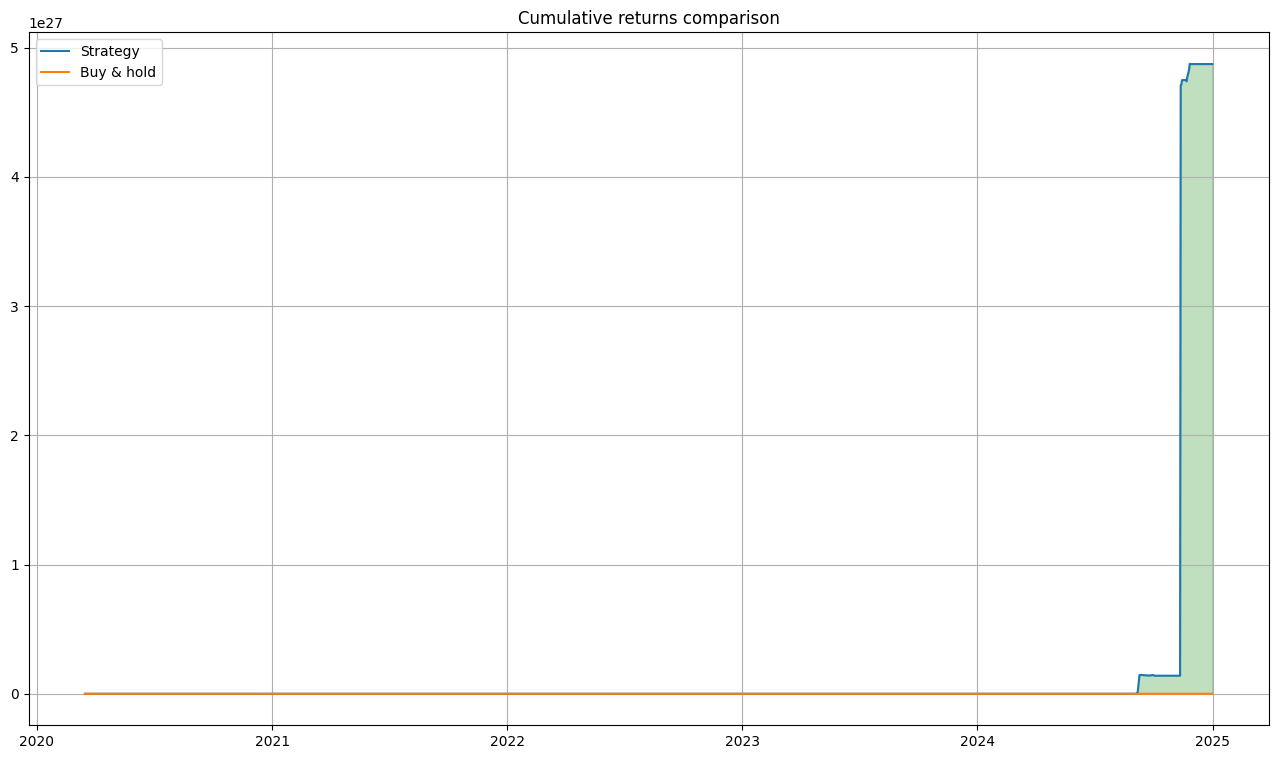

In [3]:
# ======================
# 1. Enhanced metrics calculation
# ======================
# Calculate daily returns and benchmark comparison
daily_returns = strategy_returns.pct_change().dropna()
benchmark_returns = data['Close'].pct_change().dropna()

# Calculate additional performance metrics
def calculate_performance_metrics(strategy_returns, daily_returns, trades):
    total_days = len(daily_returns)
    total_return = strategy_returns.iloc[-1]/strategy_returns.iloc[0] - 1
    
    # Annualized metrics
    annualized_return = (1 + total_return) ** (252/total_days) - 1
    annualized_vol = daily_returns.std() * np.sqrt(252)
    
    # Sortino ratio calculation
    downside_returns = daily_returns[daily_returns < 0]
    sortino_ratio = (annualized_return / downside_returns.std()) * np.sqrt(252)
    
    # Profit factor
    profits = trades[trades['profit'] > 0]['profit'].sum()
    losses = abs(trades[trades['profit'] < 0]['profit']).sum()
    profit_factor = profits / losses if losses != 0 else np.inf
    
    # Drawdown analysis
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak)/peak
    max_dd_duration = (drawdown == 0).astype(int).groupby((drawdown == 0).diff().cumsum()).cumsum().max()
    
    return {
        'Annualized return': annualized_return,
        'Annualized volatility': annualized_vol,
        'Sortino ratio': sortino_ratio,
        'Profit factor': profit_factor,
        'Max drawdown duration': max_dd_duration,
        'Daily Sharpe ratio': daily_returns.mean()/daily_returns.std() * np.sqrt(252)
    }

metrics = calculate_performance_metrics(strategy_returns, daily_returns, trades)

# ======================
# 2. Trade analysis
# ======================
# Process trade pairs
trade_results = []
for i in range(0, len(trades), 2):
    entry = trades.iloc[i]
    exit = trades.iloc[i+1]
    
    trade_results.append({
        'Entry date': entry['date'],
        'Exit date': exit['date'],
        'Duration': (exit['date'] - entry['date']).days,
        'Return': (exit['price']/entry['price'] - 1) * (-1 if entry['direction'] == 'short' else 1),
        'Profit': exit['price'] - entry['price'] if entry['direction'] == 'long' else entry['price'] - exit['price'],
        'Direction': entry['direction'],
        'Outcome': 'Win' if exit['reason'] == 'take_profit' else 'Loss'
    })

trade_df = pd.DataFrame(trade_results)

# Trade statistics
trade_stats = {
    'Total trades': len(trade_df),
    'Win rate': trade_df['Outcome'].value_counts(normalize=True).get('Win', 0),
    'Avg winning trade': trade_df[trade_df['Outcome'] == 'Win']['Return'].mean(),
    'Avg losing trade': trade_df[trade_df['Outcome'] == 'Loss']['Return'].mean(),
    'Best trade': trade_df['Return'].max(),
    'Worst trade': trade_df['Return'].min(),
    'Avg trade duration': trade_df['Duration'].mean(),
    'Max consecutive wins': max((trade_df['Outcome'] == 'Win').astype(int).groupby((trade_df['Outcome'] != 'Win').cumsum()).cumsum()),
    'Max consecutive losses': max((trade_df['Outcome'] == 'Loss').astype(int).groupby((trade_df['Outcome'] != 'Loss').cumsum()).cumsum())
}

# ======================
# 3. Time-based analysis
# ======================
# Monthly returns analysis with updated frequency strings
monthly_returns = daily_returns.resample('ME').apply(lambda x: (1 + x).prod() - 1)  # Changed 'M' to 'ME'
monthly_benchmark = benchmark_returns.resample('ME').apply(lambda x: (1 + x).prod() - 1)

# Yearly performance breakdown with updated frequency strings
yearly_stats = pd.DataFrame({
    'Strategy': daily_returns.resample('YE').apply(lambda x: (1 + x).prod() - 1),  # Changed 'Y' to 'YE'
    'Benchmark': benchmark_returns.resample('YE').apply(lambda x: (1 + x).prod() - 1)
})

# ======================
# 4. Risk analysis
# ======================
# Value at Risk and CVaR
confidence_level = 0.95
var = daily_returns.quantile(1 - confidence_level)
cvar = daily_returns[daily_returns <= var].mean()

risk_metrics = {
    '95% VaR': var,
    '95% CVaR': cvar
}

# ======================
# 5. Enhanced visualizations
# ======================
# Equity curve with drawdowns
cumulative_strategy = (1 + daily_returns).cumprod()
cumulative_benchmark = (1 + benchmark_returns).cumprod()
plt.figure(figsize=(16, 9))
plt.plot(cumulative_strategy, label='Strategy')
plt.plot(cumulative_benchmark, label='Buy & hold')
plt.fill_between(cumulative_strategy.index, cumulative_strategy, cumulative_benchmark,
                 where=(cumulative_strategy > cumulative_benchmark), 
                 interpolate=True, color='g', alpha=0.25)
plt.fill_between(cumulative_strategy.index, cumulative_strategy, cumulative_benchmark,
                 where=(cumulative_strategy <= cumulative_benchmark), 
                 interpolate=True, color='r', alpha=0.25)
plt.title('Cumulative returns comparison')
plt.legend()
plt.grid(True)
plt.show()

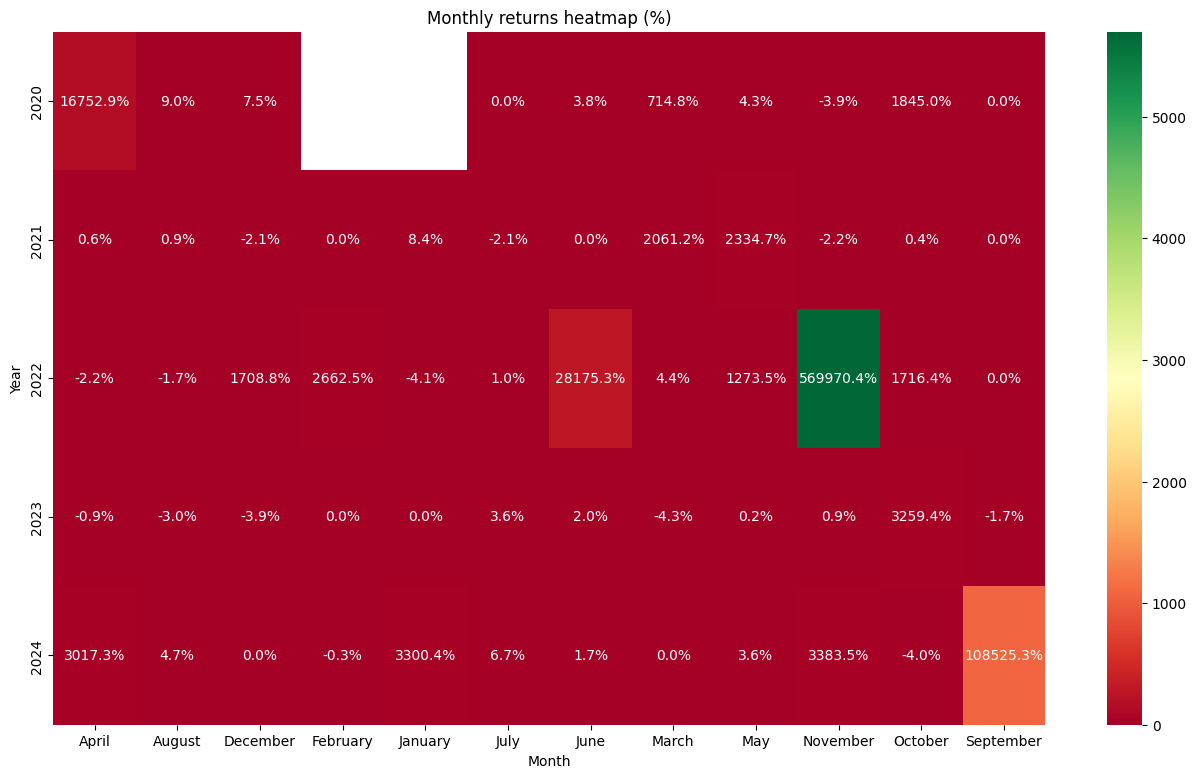

In [4]:
# Monthly returns heatmap
# Create proper DataFrame for heatmap
heatmap_df = pd.DataFrame({
    'Returns': monthly_returns,
    'Year': monthly_returns.index.year,
    'Month': monthly_returns.index.month_name()
})
pivot_table = heatmap_df.pivot_table(
    values='Returns',
    index='Year',
    columns='Month',
    aggfunc='mean'
)
plt.figure(figsize=(16, 9))
sns.heatmap(pivot_table, annot=True, fmt=".1%", cmap='RdYlGn')
plt.title('Monthly returns heatmap (%)')
plt.show()

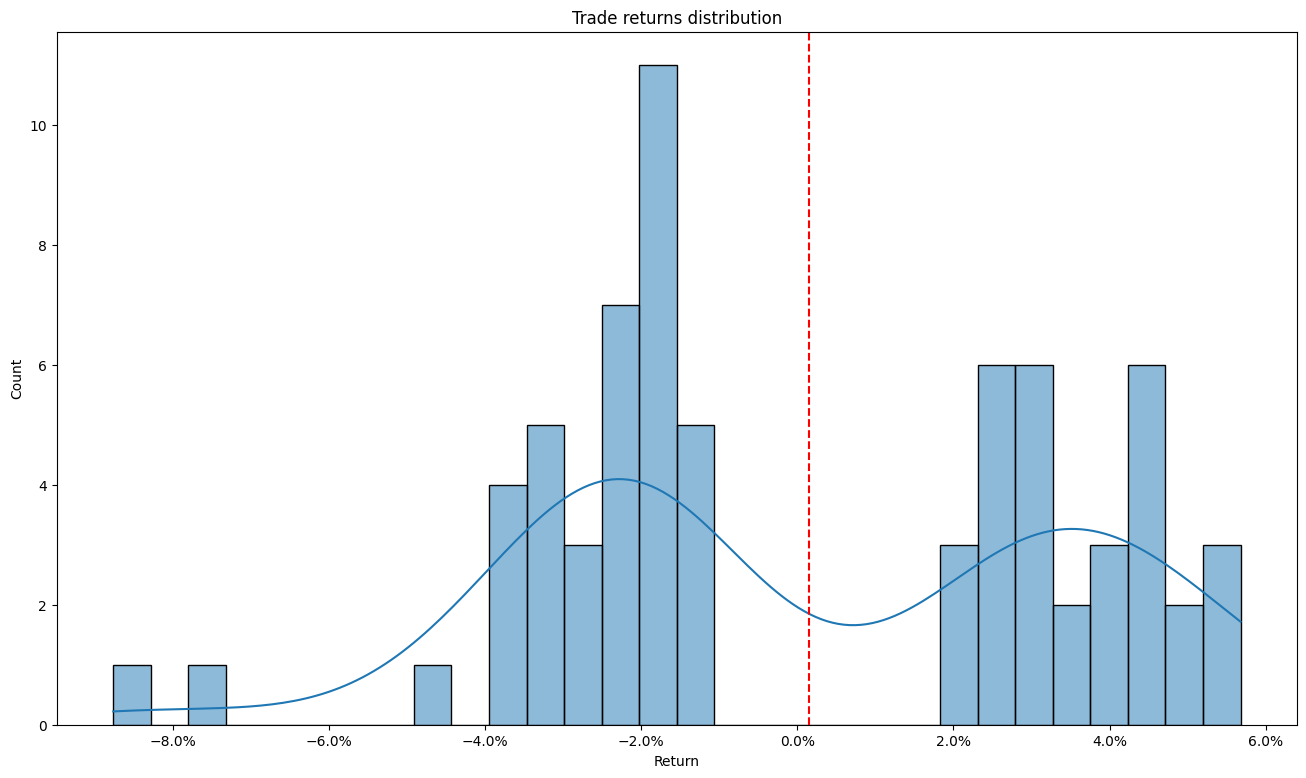

In [5]:
# Trade returns distribution
plt.figure(figsize=(16, 9))
sns.histplot(trade_df['Return'], bins=30, kde=True)
plt.axvline(trade_df['Return'].mean(), color='r', linestyle='--')
plt.title('Trade returns distribution')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.show()

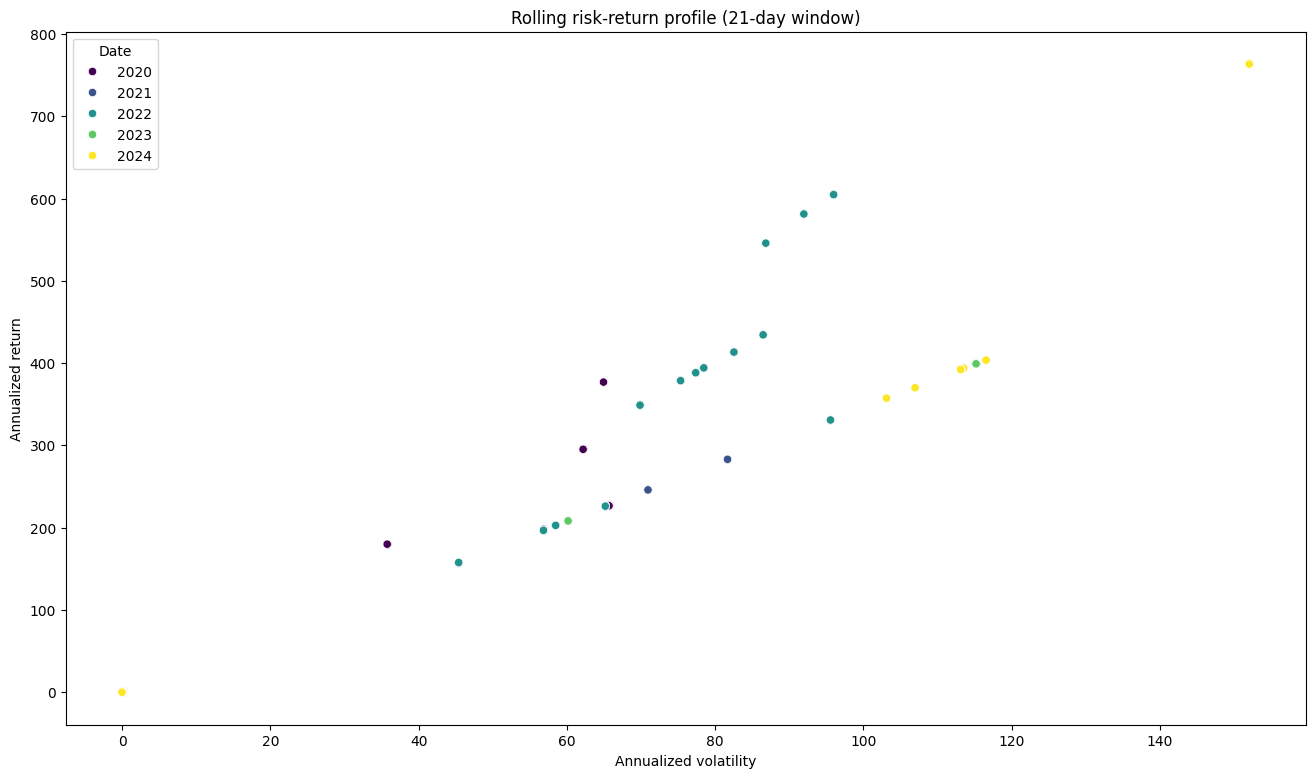


==================== STRATEGY PERFORMANCE REPORT ====================
Basic metrics
- Total return: 487338356149417142247890092032.00%
- Annualized return: 59694929.38%
- Annualized volatility: 4718.95%
- Sharpe ratio: 1.97
- Sortino ratio: 983450320.99
- Max drawdown: -11.88%
- Max drawdown duration: 42.0 days

Trade statistics
- Total trades: 69
- Win rate: 44.93%
- Profit factor: 1.10
- Avg win/avg loss ratio: 1.35
- Best trade: 5.68%
- Worst trade: -8.76%

Risk metrics
- 95% VaR: -0.85%
- 95% CVaR: -1.86%



In [6]:
# Risk-return scatter
# Use index year directly instead of resampling
plt.figure(figsize=(16, 9))
sns.scatterplot(x=daily_returns.rolling(21).std() * np.sqrt(252),
                y=daily_returns.rolling(21).mean() * 252,
                hue=daily_returns.index.year,  # Changed from resample to direct year access
                palette='viridis')
plt.xlabel('Annualized volatility')
plt.ylabel('Annualized return')
plt.title('Rolling risk-return profile (21-day window)')
plt.show()

# ======================
# 6. Print comprehensive report
# ======================

print("""
==================== STRATEGY PERFORMANCE REPORT ====================
Basic metrics
- Total return: {total_return:.2%}
- Annualized return: {annualized_return:.2%}
- Annualized volatility: {annualized_vol:.2%}
- Sharpe ratio: {sharpe:.2f}
- Sortino ratio: {sortino:.2f}
- Max drawdown: {max_dd:.2%}
- Max drawdown duration: {max_dd_duration} days

Trade statistics
- Total trades: {total_trades}
- Win rate: {win_rate:.2%}
- Profit factor: {profit_factor:.2f}
- Avg win/avg loss ratio: {win_loss_ratio:.2f}
- Best trade: {best_trade:.2%}
- Worst trade: {worst_trade:.2%}

Risk metrics
- 95% VaR: {var:.2%}
- 95% CVaR: {cvar:.2%}
""".format(
    total_return=strategy_returns.iloc[-1]/backtester.initial_capital - 1,
    annualized_return=metrics['Annualized return'],
    annualized_vol=metrics['Annualized volatility'],
    sharpe=metrics['Daily Sharpe ratio'],
    sortino=metrics['Sortino ratio'],
    max_dd=(strategy_returns/strategy_returns.cummax() - 1).min(),
    max_dd_duration=metrics['Max drawdown duration'],
    total_trades=trade_stats['Total trades'],
    win_rate=trade_stats['Win rate'],
    profit_factor=metrics['Profit factor'],
    win_loss_ratio=trade_stats['Avg winning trade']/abs(trade_stats['Avg losing trade']),
    best_trade=trade_stats['Best trade'],
    worst_trade=trade_stats['Worst trade'],
    var=risk_metrics['95% VaR'],
    cvar=risk_metrics['95% CVaR']
))

Jarque-Bera test: stat=347433.12, p-value=0.0000

ADF test: stat=-22.30, p-value=0.0000
KPSS test: stat=0.18, p-value=0.1000

T-test p-value: 0.0000
Wilcoxon signed-rank p-value: 0.0823

CAPM results:
                               SARIMAX Results                                
Dep. Variable:        Excess_strategy   No. Observations:                 1208
Model:                        SARIMAX   Log Likelihood               -3037.410
Date:                Thu, 27 Feb 2025   AIC                           6078.820
Time:                        13:25:59   BIC                           6089.014
Sample:                             0   HQIC                          6082.659
                               - 1208                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Exc

/var/folders/k1/7yl62fwx2879_758cjywcjrw0000gn/T/ipykernel_21394/2403772395.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(daily_returns)
/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Regime switching model:
                        Markov Switching Model Results                        
Dep. Variable:                      y   No. Observations:                 1208
Model:               MarkovRegression   Log Likelihood                4144.364
Date:                Thu, 27 Feb 2025   AIC                          -8276.727
Time:                        13:25:59   BIC                          -8246.147
Sample:                             0   HQIC                         -8265.212
                               - 1208                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0918      1.132      4.499      0.000       2.873       7.310
sigma2        97.8933     1

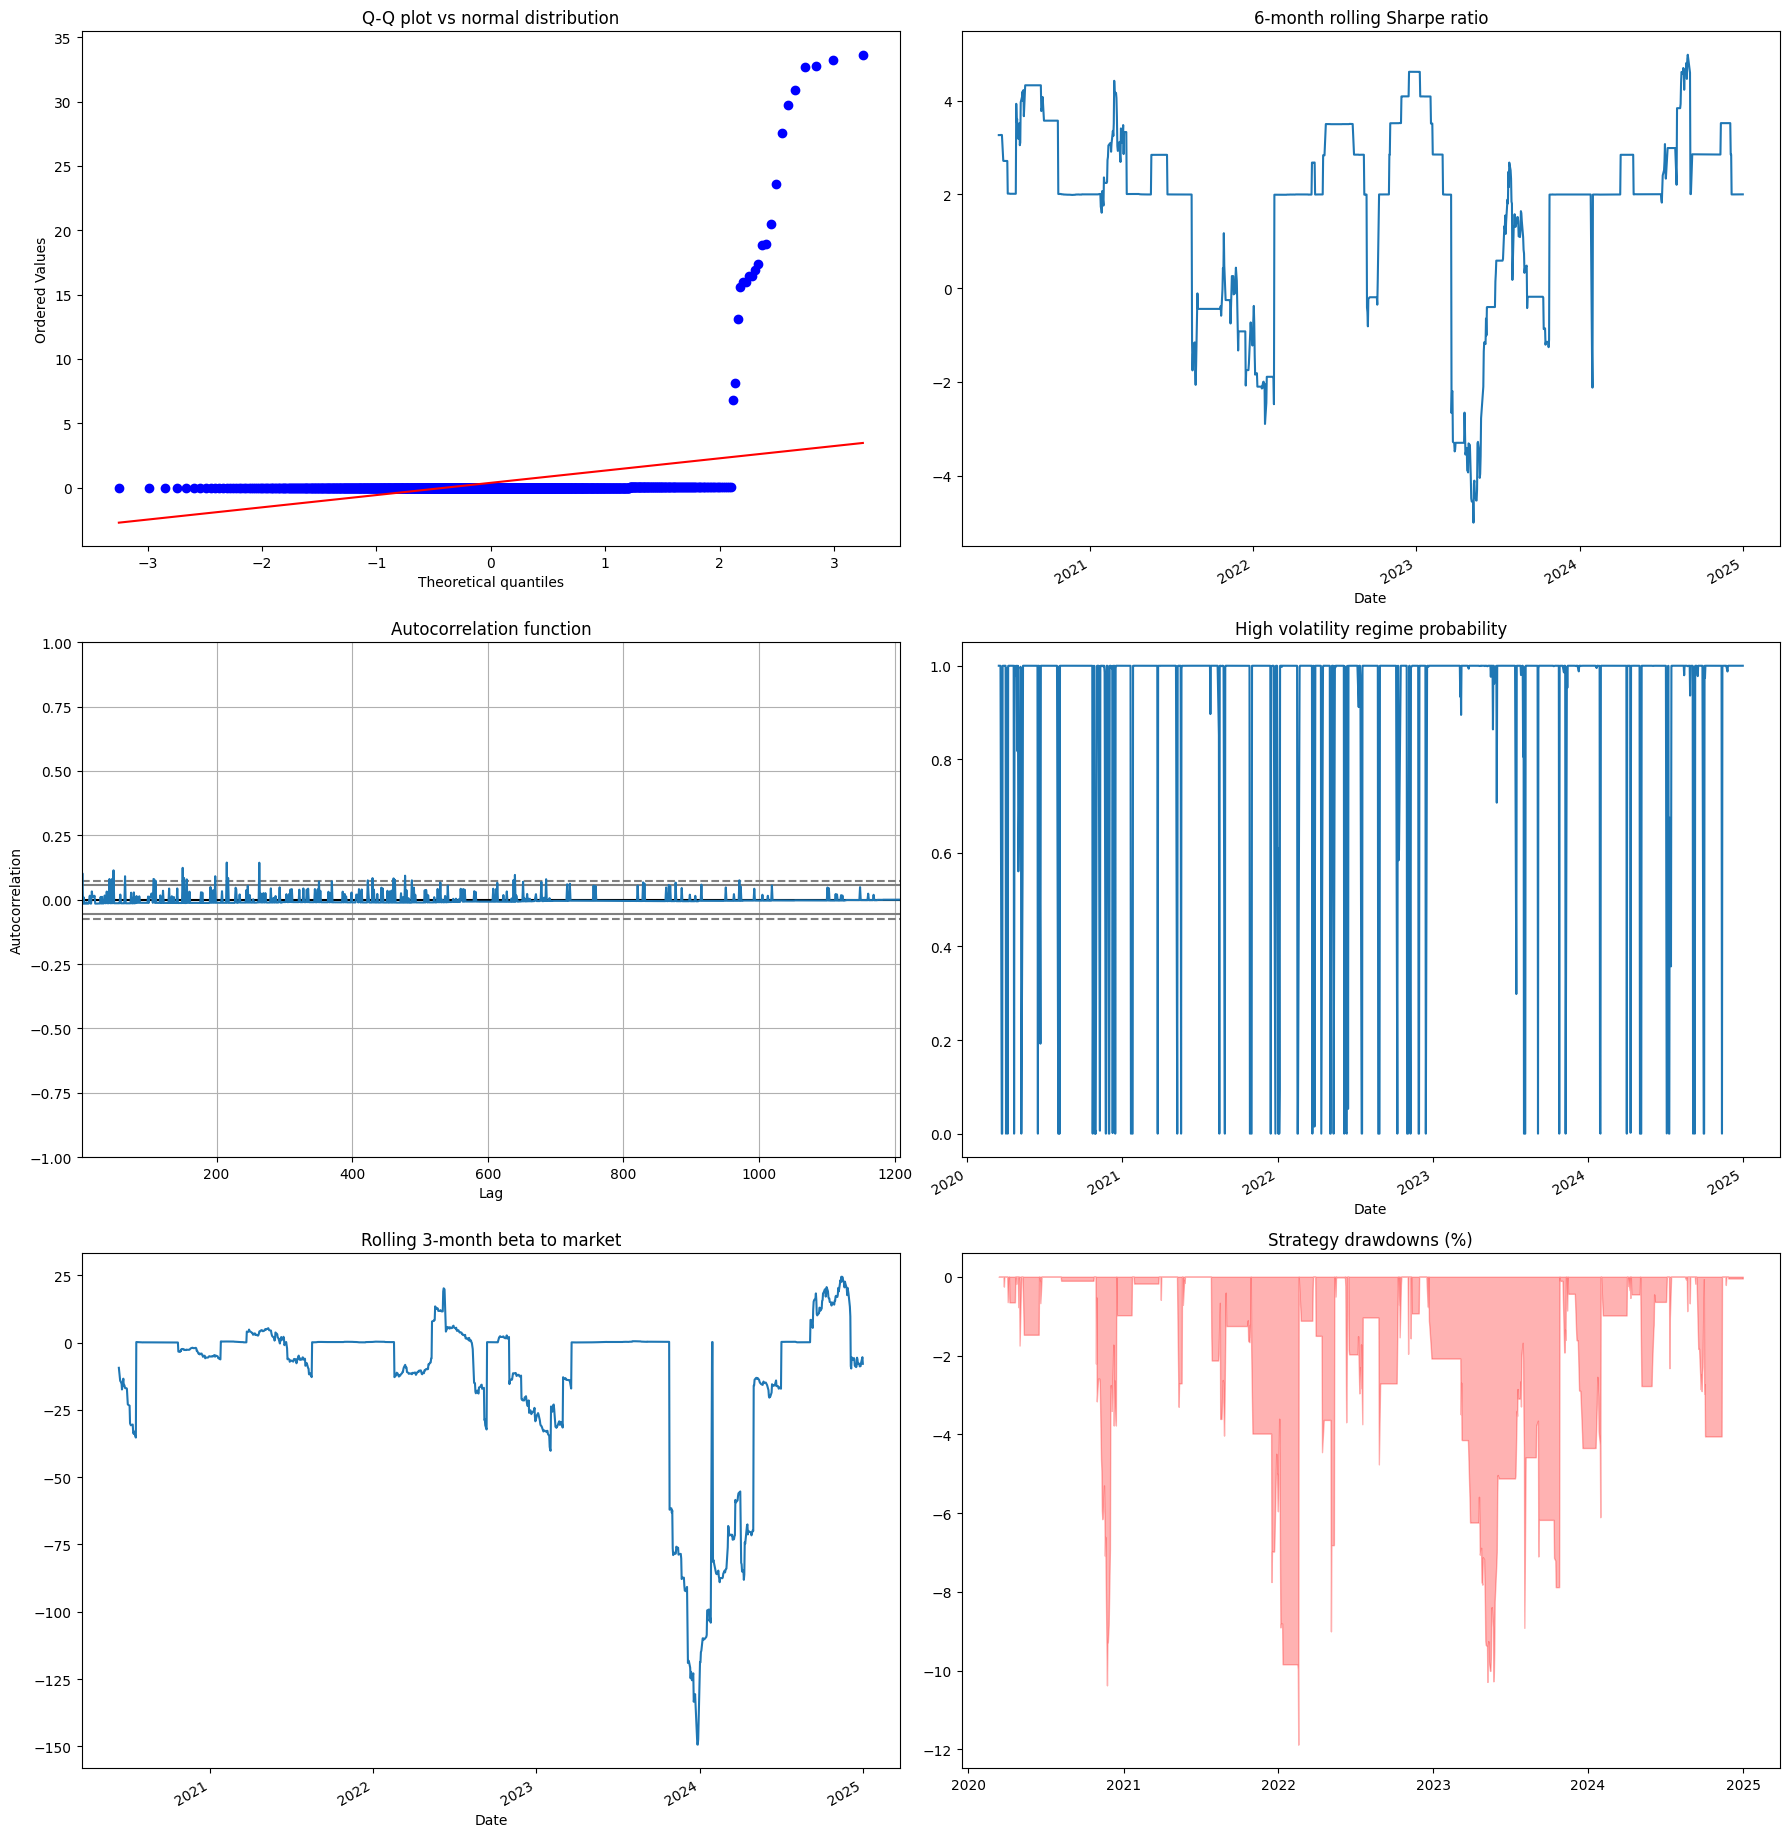


==================== ADVANCED STRATEGY ANALYSIS ====================
Statistical tests
- Returns normality (Jarque-Bera): p-value=0.0000
- Stationarity (ADF): p-value=0.0000
- Outperformance (Wilcoxon): p-value=0.0823
- ARCH effects: p-value=0.0464

Advanced risk metrics
- Conditional skewness: 8.81
- Conditional kurtosis: 81.54
- Ulcer index: 0.03
- Recovery factor: 410202260939941967621123720871936.00
- Tail ratio: 1.70

Factor analysis
- CAPM alpha: -774.31% (p=0.198)
- Market beta: 8.94
- High volatility regime probability: 92.7%

Stress test performance
COVID-19 crash: Return=677.56%, DD=0.00%
2022 bear market: Return=185181423.68%, DD=-6.30%



/var/folders/k1/7yl62fwx2879_758cjywcjrw0000gn/T/ipykernel_21394/2403772395.py:234: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha=capm_model.params[0],
/var/folders/k1/7yl62fwx2879_758cjywcjrw0000gn/T/ipykernel_21394/2403772395.py:235: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_p=capm_model.pvalues[0],
/var/folders/k1/7yl62fwx2879_758cjywcjrw0000gn/T/ipykernel_21394/2403772395.py:236: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

In [7]:
# ======================
# 7. Statistical analysis
# ======================

# Normality tests
jb_test = jarque_bera(daily_returns)
print(f"Jarque-Bera test: stat={jb_test[0]:.2f}, p-value={jb_test[1]:.4f}")

# Stationarity tests
adf_result = adfuller(daily_returns)
kpss_result = kpss(daily_returns)
print(f"\nADF test: stat={adf_result[0]:.2f}, p-value={adf_result[1]:.4f}")
print(f"KPSS test: stat={kpss_result[0]:.2f}, p-value={kpss_result[1]:.4f}")

# Strategy vs benchmark comparison
_, p_ttest = ttest_ind(daily_returns, benchmark_returns, equal_var=False)
_, p_wilcoxon = wilcoxon(daily_returns, benchmark_returns)
print(f"\nT-test p-value: {p_ttest:.4f}")
print(f"Wilcoxon signed-rank p-value: {p_wilcoxon:.4f}")

# ======================
# 8. Econometric analysis
# ======================

# 1. Factor model regression (CAPM)
merged_returns = pd.DataFrame({
    'Strategy': daily_returns,
    'Market': benchmark_returns,
    'RF': 0  # Assuming zero risk-free rate for simplicity
}).dropna()

merged_returns['Excess_strategy'] = merged_returns['Strategy'] - merged_returns['RF']
merged_returns['Excess_market'] = merged_returns['Market'] - merged_returns['RF']

capm_model = SARIMAX(merged_returns['Excess_strategy'],
                     exog=merged_returns['Excess_market'],
                     order=(0,0,0)).fit(disp=False)
print("\nCAPM results:")
print(capm_model.summary())

# 2. ARCH effects test
arch_test = het_arch(daily_returns)
print(f"\nARCH-LM test: F-stat={arch_test[2]:.2f}, p-value={arch_test[3]:.4f}")

# 3. Regime switching model (Markov switching)
def run_regime_analysis(returns_series):
    # Convert returns_series to daily frequency and drop missing values
    returns_data = returns_series.asfreq('D').dropna().to_numpy()
    
    # Define starting parameters for optimization:
    # [const0, const1, sigma0, sigma1, p00, p11]
    start_params = np.array([0.0, 0.0, 1.0, 1.0, 0.9, 0.9])
    
    try:
        # Initialize the model without initial_params in the constructor
        model = MarkovRegression(returns_data, k_regimes=2, trend='c', switching_variance=True)
        
        # Pass the starting parameters to the fit() method
        regime_results = model.fit(method='powell', start_params=start_params, maxiter=1000, disp=False)
        
        # Check for convergence
        if not regime_results.mle_retvals.get('converged', True):
            print("Warning: Optimization did not fully converge. Results may be approximate.")
        return regime_results
    
    except Exception as e:
        print(f"Regime switching failed: {str(e)}")
        return None

# Run the improved analysis
regime_results = run_regime_analysis(daily_returns)

if regime_results is not None:
    print("\nRegime switching model:")
    print(regime_results.summary())
    
    try:
        # Extract the probability series for regime 1 using proper slicing
        regime_prob = regime_results.smoothed_marginal_probabilities[:, 1]
        
        # Use the same index as the daily_returns series used for fitting
        returns_index = daily_returns.asfreq('D').dropna().index
        
        # Now convert to a pandas Series and plot
        regime_prob_series = pd.Series(regime_prob, index=returns_index)

    except Exception as e:
        print(f"Could not plot regime probabilities: {str(e)}")
else:
    print("Could not estimate regime switching model")

# ======================
# 9. Advanced risk analysis
# ======================

# Tail risk metrics
conditional_skew = daily_returns.skew()
conditional_kurtosis = daily_returns.kurtosis()
var_99 = daily_returns.quantile(0.01)

# Advanced drawdown analysis
drawdown = (strategy_returns - strategy_returns.cummax()) / strategy_returns.cummax()
ulcer_index = np.sqrt((drawdown**2).mean())
recovery_factor = -strategy_returns.iloc[-1]/drawdown.min()

risk_metrics.update({
    'Conditional skewness': conditional_skew,
    'Conditional kurtosis': conditional_kurtosis,
    '99% VaR': var_99,
    'Ulcer index': ulcer_index,
    'Recovery factor': recovery_factor
})

# ======================
# 10. Advanced visualizations
# ======================

plt.figure(figsize=(18, 24))

# Q-Q plot
ax1 = plt.subplot(4, 2, 1)
stats.probplot(daily_returns, dist="norm", plot=plt)
plt.title('Q-Q plot vs normal distribution')

# Rolling Sharpe ratio
ax2 = plt.subplot(4, 2, 2)
rolling_sharpe = (daily_returns.rolling(63).mean() / 
                 daily_returns.rolling(63).std() * np.sqrt(252))
rolling_sharpe.plot()
plt.title('6-month rolling Sharpe ratio')

# Autocorrelation analysis
ax3 = plt.subplot(4, 2, 3)
pd.plotting.autocorrelation_plot(daily_returns)
plt.title('Autocorrelation function')

# Regime probability plot
ax4 = plt.subplot(4, 2, 4)
regime_prob_series.plot()
plt.title('High volatility regime probability')

# Factor exposure rolling beta
ax5 = plt.subplot(4, 2, 5)
merged_returns['rolling_beta'] = merged_returns['Excess_strategy'].rolling(63).cov(
    merged_returns['Excess_market']) / merged_returns['Excess_market'].rolling(63).var()
merged_returns['rolling_beta'].plot()
plt.title('Rolling 3-month beta to market')

# Drawdown periods
ax6 = plt.subplot(4, 2, 6)
plt.fill_between(drawdown.index, drawdown*100, 0, color='red', alpha=0.3)
plt.title('Strategy drawdowns (%)')

plt.tight_layout()
plt.show()

# ======================
# 11. Advanced performance metrics
# ======================

# Omega ratio
threshold = 0
omega_ratio = (daily_returns[daily_returns > threshold].mean() / 
              abs(daily_returns[daily_returns <= threshold].mean()))

# Calmar ratio
calmar_ratio = metrics['Annualized return'] / abs(drawdown.min())

# Tail ratio
tail_ratio = (daily_returns.quantile(0.95) / 
             abs(daily_returns.quantile(0.05)))

metrics.update({
    'Omega ratio': omega_ratio,
    'Calmar ratio': calmar_ratio,
    'Tail ratio': tail_ratio
})

# ======================
# 12. Stress testing
# ======================

# Historical stress periods
stress_periods = {
    'COVID-19 crash': ('2020-02-20', '2020-03-23'),
    '2022 bear market': ('2022-01-03', '2022-10-12')
}

stress_results = {}
for name, (start, end) in stress_periods.items():
    period_returns = daily_returns.loc[start:end]
    stress_results[name] = {
        'Cumulative return': (1 + period_returns).prod() - 1,
        'Max drawdown': (1 + period_returns).cumprod().min() - 1,
        'Volatility': period_returns.std() * np.sqrt(252)
    }

# ======================
# 13. Final comprehensive report
# ======================

print("""
==================== ADVANCED STRATEGY ANALYSIS ====================
Statistical tests
- Returns normality (Jarque-Bera): p-value={jb_p:.4f}
- Stationarity (ADF): p-value={adf_p:.4f}
- Outperformance (Wilcoxon): p-value={wilcoxon_p:.4f}
- ARCH effects: p-value={arch_p:.4f}

Advanced risk metrics
- Conditional skewness: {skew:.2f}
- Conditional kurtosis: {kurtosis:.2f}
- Ulcer index: {ulcer:.2f}
- Recovery factor: {recovery:.2f}
- Tail ratio: {tail_ratio:.2f}

Factor analysis
- CAPM alpha: {alpha:.2%} (p={alpha_p:.3f})
- Market beta: {beta:.2f}
- High volatility regime probability: {regime_prob:.1%}

Stress test performance
{stress_tests}
""".format(
    jb_p=jb_test[1],
    adf_p=adf_result[1],
    wilcoxon_p=p_wilcoxon,
    arch_p=arch_test[3],
    skew=risk_metrics['Conditional skewness'],
    kurtosis=risk_metrics['Conditional kurtosis'],
    ulcer=risk_metrics['Ulcer index'],
    recovery=risk_metrics['Recovery factor'],
    tail_ratio=metrics['Tail ratio'],
    alpha=capm_model.params[0],
    alpha_p=capm_model.pvalues[0],
    beta=capm_model.params[1],
    regime_prob=regime_prob.mean(),
    stress_tests="\n".join([f"{name}: Return={res['Cumulative return']:.2%}, DD={res['Max drawdown']:.2%}"
                          for name, res in stress_results.items()])
))